# Compare atmospheric forcing

Between ERA5, CESM1, CESM2

In [1]:
import xarray as xr
import numpy as np
import cmocean
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.constants import cesm2_ensemble_members, region_names
from nemo_python_git.grid import region_mask
from nemo_python_git.utils import fix_lon_range
from nemo_python_git.file_io import find_cesm2_file, find_processed_cesm2_file

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'

### Regional mean monthly timeseries of atmospheric forcing:

In [3]:
variable='TREFHT'; 
year_start=1979; year_end=1980;

era5_folder  =f'{base_dir}ERA5-forcing/daily/files/'
cesm1_folder =f'{base_dir}climate-forcing/CESM1/LENS/'
cesm2_folder =f'{base_dir}climate-forcing/CESM2/LE2/'

Load CESM1 files:

In [29]:
# b.e11.B20TRC5CNBDRD.f09_g16.013.cam.h0.TREFHT.192001-200512.nc 
CESM1_ds = xr.open_mfdataset(f'{cesm1_folder}*{variable}*.nc', concat_dim='ens', combine='nested')[variable].sel(lat=slice(-90,-50))
CESM1_ds = CESM1_ds.isel(time=((CESM1_ds.time.dt.year <= year_end)*(CESM1_ds.time.dt.year >= year_start)))
CESM1_ds['lon'] = fix_lon_range(CESM1_ds['lon'])
CESM1_ds = CESM1_ds.sortby('lon').resample(time="ME").mean().drop_isel(lat=[20,24,33])
land_mask = cesm2_landmask.sel(lat=slice(-90,-50)).sortby('lon')
land_mask['lat'] = CESM1_ds['lat']
CESM1_ocn = xr.where(land_mask==0, CESM1_ds, np.nan)

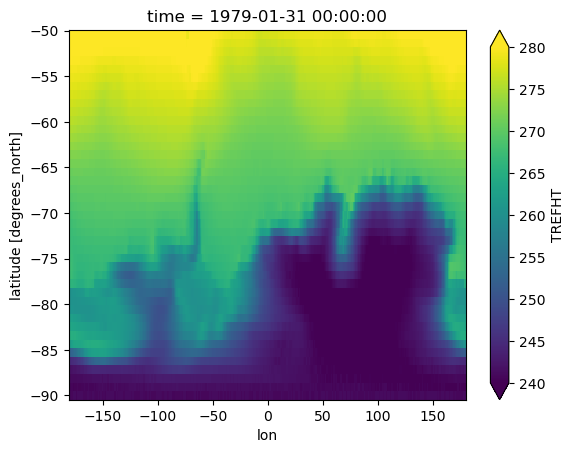

In [33]:
CESM1_ds.mean(dim='ens').isel(time=0).plot(vmin=240, vmax=280)

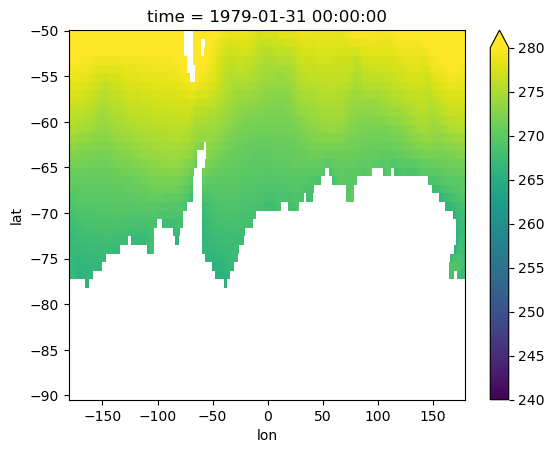

In [32]:
CESM1_ocn.mean(dim='ens').isel(time=0).plot(vmin=240, vmax=280)

In [44]:
# now calculate regional means: weddell gyre region and maud rise polynya region
cesm1_circum       = CESM1_ds.mean(dim=('lat','lon'))
cesm1_weddell_gyre = CESM1_ds.sel(lon=slice(-60,-10) , lat=slice(-80,-60)).mean(dim=('lat','lon'))
cesm1_maud_rise    = CESM1_ds.sel(lon=slice(0,120)   , lat=slice(-72,-55)).mean(dim=('lat','lon'))
cesm1_amundsen     = CESM1_ds.sel(lon=slice(-140,-80), lat=slice(-75,-63)).mean(dim=('lat','lon'))

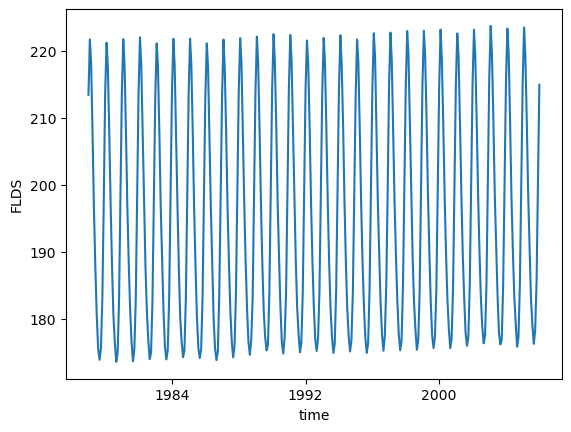

In [47]:
cesm1_circum.mean(dim='ens').plot()

Load CESM2 files:

In [5]:
cesm2_landmask = xr.open_dataset(f'{cesm2_folder}b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h0.LANDFRAC.185001-185912.nc').LANDFRAC.isel(time=0)
cesm2_landmask['lon'] = fix_lon_range(cesm2_landmask['lon'])

In [18]:
# Load ensembles dataset
for e, ens in enumerate(cesm2_ensemble_members):
    files_to_open = []
    for year in range(year_start, year_end+1):
        file_path     = find_processed_cesm2_file('LE2', variable, ens, year)
        files_to_open += [file_path]
    
    if e==0:
        ensemble_ds = xr.open_mfdataset(files_to_open).sel(lat=slice(-90,-50)).sortby('lon')
    else:
        ens_ds = xr.open_mfdataset(files_to_open).sel(lat=slice(-90,-50)).sortby('lon')
        ensemble_ds = xr.concat([ensemble_ds, ens_ds], 'ens')

# resample data to monthly mean and mask land
monthly_ds  = ensemble_ds.resample(time="ME").mean()
land_mask   = cesm2_landmask.sel(lat=slice(-90,-50)).sortby('lon')
monthly_ocn = xr.where(land_mask==0, monthly_ds[variable], np.nan)

In [19]:
# now calculate regional means: weddell gyre region and maud rise polynya region
cesm2_circum       = monthly_ocn.mean(dim=('lat','lon'))
cesm2_weddell_gyre = monthly_ocn.sel(lon=slice(-60,-10) , lat=slice(-80,-60)).mean(dim=('lat','lon'))
cesm2_maud_rise    = monthly_ocn.sel(lon=slice(0,120)   , lat=slice(-72,-55)).mean(dim=('lat','lon'))
cesm2_amundsen     = monthly_ocn.sel(lon=slice(-140,-80), lat=slice(-75,-63)).mean(dim=('lat','lon'))
cesm2_longitude     = monthly_ocn.mean(dim='lon')

ERA5 forcing

In [20]:
era5_landmask = xr.open_dataset(f'{era5_folder}land_sea_mask.nc').isel(valid_time=0).lsm
era5_landmask['longitude'] = fix_lon_range(era5_landmask['longitude'])
era5_landmask = era5_landmask.sel(latitude=slice(-50,-90)).sortby('longitude')

CESM2_to_ERA5_varnames = {'TREFHT':'t2m','FSDS':'msdwswrf','FLDS':'msdwlwrf','PRECS':'msr', 'PRECT':'mtpr'}

In [21]:
era5_var = CESM2_to_ERA5_varnames[variable]; 
ERA5_ds  = xr.open_mfdataset(f'{era5_folder}{era5_var}_*.nc').sel(latitude=slice(-50,-90)).sortby('longitude').rename({'valid_time':'time'})
ERA5_ds  = ERA5_ds.isel(time=((ERA5_ds.time.dt.year <= year_end)*(ERA5_ds.time.dt.year >= year_start)))

# resample data to monthly mean and mask land
ERA5_monthly_ds  = ERA5_ds.resample(time="ME").mean()
ERA5_monthly_ocn = xr.where(era5_landmask==0, ERA5_monthly_ds[era5_var], np.nan)

In [22]:
# now calculate regional means: weddell gyre region and maud rise polynya region
era5_circum       = ERA5_monthly_ocn.mean(dim=('latitude','longitude'))
era5_weddell_gyre = ERA5_monthly_ocn.sel(longitude=slice(-60,-10) , latitude=slice(-60,-80)).mean(dim=('latitude','longitude'))
era5_maud_rise    = ERA5_monthly_ocn.sel(longitude=slice(0,120)   , latitude=slice(-55,-72)).mean(dim=('latitude','longitude'))
era5_amundsen     = ERA5_monthly_ocn.sel(longitude=slice(-140,-80), latitude=slice(-63,-75)).mean(dim=('latitude','longitude'))
era5_longitude    = ERA5_monthly_ocn.mean(dim='longitude')

Plot

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,9))
fig.suptitle(variable)

# --- CESM2 ---------------------
# for ens, ens_name in enumerate(cesm2_ensemble_members):
#     kwags = {'label':ens_name, 'linewidth':0.5}
#     ax[0,0].plot(cesm2_circum.time      , cesm2_circum.isel(ens=ens)      ,**kwags)
#     ax[0,1].plot(cesm2_weddell_gyre.time, cesm2_weddell_gyre.isel(ens=ens),**kwags)
#     ax[1,0].plot(cesm2_amundsen.time    , cesm2_amundsen.isel(ens=ens)    ,**kwags)
#     ax[1,1].plot(cesm2_maud_rise.time   , cesm2_maud_rise.isel(ens=ens)   ,**kwags)

kwags_cesm2_ensmean = {'label':'CESM2 ensemble mean', 'linewidth':2.5}
ax[0,0].plot(cesm2_circum.time      , cesm2_circum.mean(dim='ens')       ,**kwags_cesm2_ensmean)
ax[0,1].plot(cesm2_weddell_gyre.time, cesm2_weddell_gyre.mean(dim='ens') ,**kwags_cesm2_ensmean)
ax[1,0].plot(cesm2_amundsen.time    , cesm2_amundsen.mean(dim='ens')     ,**kwags_cesm2_ensmean)
ax[1,1].plot(cesm2_maud_rise.time   , cesm2_maud_rise.mean(dim='ens')    ,**kwags_cesm2_ensmean)

# --- ERA5 ---------------------
kwags_era5 = {'label':'ERA5', 'linewidth':2.5}
ax[0,0].plot(era5_circum.time      , era5_circum      ,**kwags_era5)
ax[0,1].plot(era5_weddell_gyre.time, era5_weddell_gyre,**kwags_era5)
ax[1,0].plot(era5_amundsen.time    , era5_amundsen    ,**kwags_era5)
ax[1,1].plot(era5_maud_rise.time   , era5_maud_rise   ,**kwags_era5)

regions=['Circumpolar', 'Weddell Gyre', 'Amundsen Sea', 'Maud Rise']
for a, axis in enumerate(ax.ravel()):
    axis.set_title(regions[a])
    
ax[0,1].legend(loc=(1.05, 0.5))

In [6]:
land_mask = cesm2_landmask.sel(lat=slice(-90,-50)).sortby('lon')
CESM1_ocn = xr.where(land_mask.values==0, CESM1_ds.drop_isel(lat=[20,24,33]), np.nan)

NameError: name 'CESM1_ds' is not defined